In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['online-news-popularity-dataset']
/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv


# MLPRegression and MLPClassification

## Preprocessing

In [2]:
df = pd.read_csv("../input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

This looks like exponential distribution.

(0.0, 15000.0)

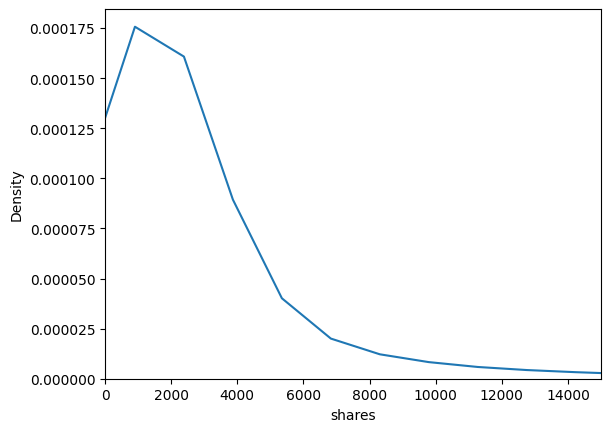

In [4]:
sns.kdeplot(df['shares'])
plt.xlim(0, 15000)

Lets drop columns `url`, because variable unique for all data set.

In [5]:
df.drop(columns=['url'], axis=1, inplace=True)

Let also delete `kw_min_min kw_max_max n_non_stop_words` collumns, because all values same.

In [6]:
df['kw_max_max'].value_counts()

kw_max_max
843300    4951
663600       2
233400       1
Name: count, dtype: int64

In [7]:
df['kw_min_min'].value_counts()

kw_min_min
-1    4954
Name: count, dtype: int64

In [8]:
df['n_non_stop_words'].value_counts()

n_non_stop_words
1.0    1020
1.0     792
1.0     599
1.0     488
0.0     488
1.0     469
1.0     353
1.0     204
1.0     155
1.0     106
1.0      75
1.0      63
1.0      44
1.0      24
1.0      23
1.0      13
1.0       8
1.0       8
1.0       4
1.0       3
1.0       3
1.0       2
1.0       2
1.0       2
1.0       2
1.0       2
1.0       1
1.0       1
Name: count, dtype: int64

In [9]:
garbage = ['kw_max_max', 'kw_min_min', 'n_non_stop_words']
df.drop(columns=garbage, axis=1, inplace=True)

Lets delete anomaly articles that have `shares`>=15000 and <400 and log our target variable to make distribution more familiar to normal.

In [10]:
df['shares'].value_counts()

shares
1100     316
1200     279
1300     225
1400     224
1500     165
        ... 
26900      1
569        1
19100      1
477        1
470        1
Name: count, Length: 781, dtype: int64

In [11]:
df = df[df['shares'] <= 15000]
df = df[df['shares'] > 200]

<Axes: xlabel='shares', ylabel='Density'>

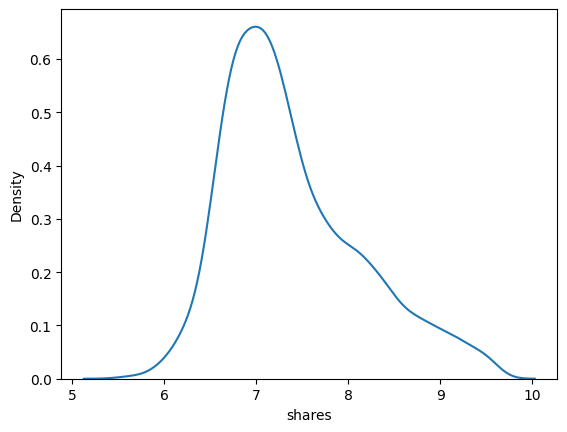

In [12]:
y_regretion = np.log(df['shares'])
sns.kdeplot(y_regretion)

Like previous model, lets also see classification issues.

In [13]:
df['is_popular'] = (df['shares'] > 1500).astype(int)
df.drop(columns=['shares'], axis=1, inplace=True)
df['is_popular'].value_counts()

is_popular
0    2741
1    2041
Name: count, dtype: int64

## Split Data

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop('is_popular', axis=1)
y_classification = df['is_popular']
X_train, X_valid, y_train_cl, y_valid_cl = train_test_split(X, y_classification, test_size=0.25, random_state=4)
X_train, X_valid, y_train_reg, y_valid_reg = train_test_split(X, y_regretion, test_size=0.25, random_state=4)

Lets standart data

In [15]:
from sklearn.preprocessing import StandardScaler

For regression

In [16]:
scaler_reg = StandardScaler()
scaler_reg.fit(X_train, y_train_reg)

X_train_st_reg = scaler_reg.transform(X_train)
X_valid_st_reg = scaler_reg.transform(X_valid)

For classification

In [17]:
scaler_cl = StandardScaler()
scaler_cl.fit(X_train, y_train_cl)

X_train_st_cl = scaler_cl.transform(X_train)
X_valid_st_cl = scaler_cl.transform(X_valid)

## Classifier and Regressor

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

Lets build our models and check result

In [19]:
mlp_reg = MLPRegressor(solver='lbfgs', max_iter=20000, random_state=23)
mlp_reg.fit(X_train_st_reg, y_train_cl)

y_pred_reg = mlp_reg.predict(X_valid_st_reg)
print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))

mean_squared_error score: 48.89624979816056
r2 score: -87.98012203557035


In [20]:
mlp_cl = MLPClassifier(solver='lbfgs', max_iter=200, random_state=23)
mlp_cl.fit(X_train_st_cl, y_train_cl)

y_pred_cl = mlp_cl.predict(X_valid_st_cl)
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

f1 score: 0.5691699604743082


Not bad result for classification, but lets try to make better result with parameters

## SearchCV

In [21]:
from sklearn.model_selection import RandomizedSearchCV

We have 4 params. In hidden_layer_sizes we can change layers and number of layers.

In [22]:
np.random.seed(52)
params = {
    'alpha': np.logspace(-4, 4, 10),
    'hidden_layer_sizes': [ tuple(np.random.choice((20, 30, 50, 80), i)) for i in range(1, 4)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [50000]
}
j=0
for i in params['hidden_layer_sizes']:
    j+=1
    print(j,"Hiden",len(i), "layers with neurons:", *i)

1 Hiden 1 layers with neurons: 30
2 Hiden 2 layers with neurons: 20 80
3 Hiden 3 layers with neurons: 30 80 50


In [23]:
MLPRegressor_CV = RandomizedSearchCV(mlp_reg, params, cv=5, scoring='r2', n_jobs=-1, random_state=52)
MLPClassifier_CV = RandomizedSearchCV(mlp_cl, params, cv=5, scoring='f1', n_jobs=-1, random_state=52)

In [24]:
MLPRegressor_CV.fit(X_train_st_reg, y_train_reg)

RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(max_iter=20000, random_state=23,
                                          solver='lbfgs'),
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                                        'hidden_layer_sizes': [(30,), (20, 80),
                                                               (30, 80, 50)],
                                        'learning_rate_init': [0.0001, 0.001,
                                                               0.01, 0.1],
                                        'max_iter': [50000]},
                   random_state=52, scoring='r2')

In [25]:
MLPClassifier_CV.fit(X_train_st_cl, y_train_cl)

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(random_state=23, solver='lbfgs'),
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                                        'hidden_layer_sizes': [(30,), (20, 80),
                                                               (30, 80, 50)],
                                        'learning_rate_init': [0.0001, 0.001,
                                                               0.01, 0.1],
                                        'max_iter': [50000]},
                   random_state=52, scoring='f1')

In [26]:
print("Best params for classification:", MLPClassifier_CV.best_params_)
print("Best score for classification:", MLPClassifier_CV.best_score_)
print("Best params for regressor:", MLPRegressor_CV.best_params_)
print("Best r2 for regressor:", MLPRegressor_CV.best_score_)

Best params for classification: {'max_iter': 50000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (30,), 'alpha': 2.782559402207126, 'activation': 'relu'}
Best score for classification: 0.5446840343202712
Best params for regressor: {'max_iter': 50000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20, 80), 'alpha': 10000.0, 'activation': 'logistic'}
Best r2 for regressor: -0.001169114836156826


`relu` activator, have best result, learning_rate_init 0.01

We have worse f1 score, and bad for r2

In [27]:
best_cl = MLPClassifier_CV.best_estimator_
best_reg = MLPRegressor_CV.best_estimator_
y_pred_cl = best_cl.predict(X_valid_st_cl)
y_pred_reg = best_cl.predict(X_valid_st_reg)
print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 48.956203909586705
r2 score: -88.08922496622972
f1 score: 0.5666991236611489


Lets build valid curve

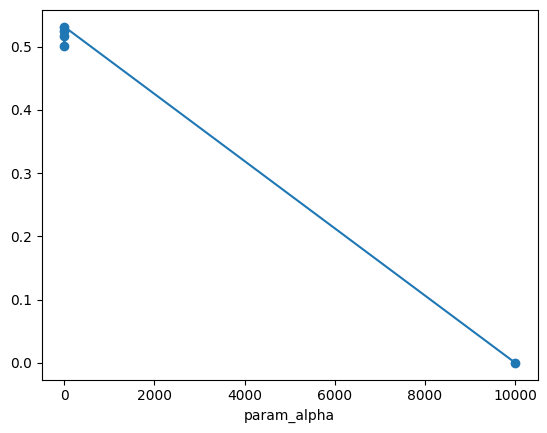

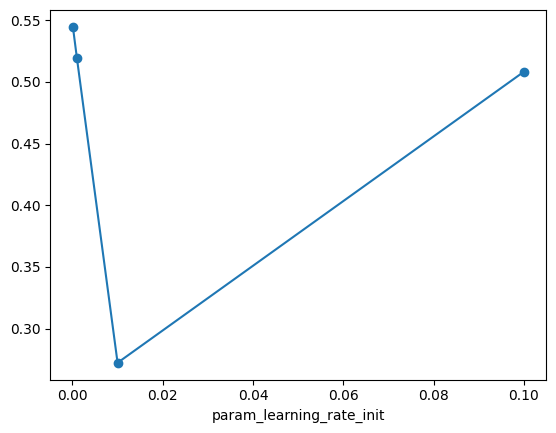

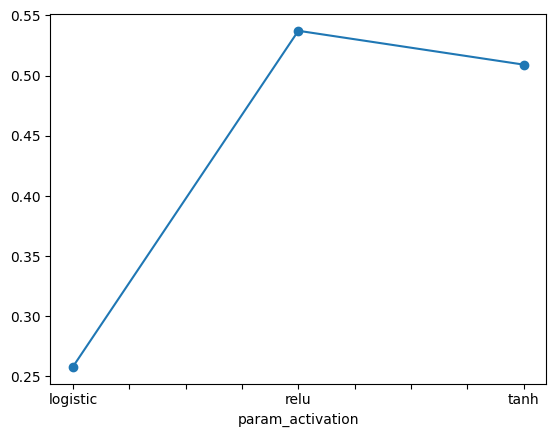

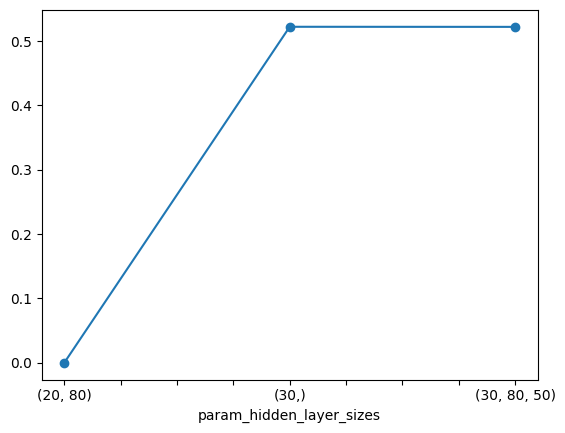

In [28]:
result = pd.DataFrame(MLPClassifier_CV.cv_results_)
for feature in ['param_alpha','param_learning_rate_init', 'param_activation', 'param_hidden_layer_sizes']:
  result.groupby(feature)['mean_test_score'].mean().plot(marker='o')
  plt.show()

We can see that one hidden layer have better result than two and same result with 3. 

Conclusion: we didnt make better model than default model.

## Bagging KNN

Now lets try another models using bagging and boosting

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [30]:
bagging_cl = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, n_estimators=10)
bagging_reg = BaggingRegressor(KNeighborsRegressor(), max_samples=0.5, max_features=1.0, n_estimators=10)

In [31]:
bagging_cl.fit(X_train_st_cl, y_train_cl)

BaggingClassifier(estimator=KNeighborsClassifier(), max_samples=0.5)

In [32]:
bagging_reg.fit(X_train_st_reg, y_train_reg)

BaggingRegressor(estimator=KNeighborsRegressor(), max_samples=0.5)

In [33]:
y_pred_cl = bagging_cl.predict(X_valid_st_cl)
y_pred_reg = bagging_reg.predict(X_valid_st_reg)

print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.530560570048568
r2 score: 0.03449969138616171
f1 score: 0.5063879210220673


We have worse result for classification and much better result for regression. But let try make better result with parameters.

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
params_bg = { 'n_estimators': list(range(1, 100, 2)) }
bg_cl_CV = GridSearchCV(bagging_cl, params_bg, cv=5, scoring='f1')
bg_reg_CV = GridSearchCV(bagging_reg, params_bg, cv=5, scoring='r2')

In [36]:
bg_cl_CV.fit(X_train_st_cl, y_train_cl)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=KNeighborsClassifier(),
                                         max_samples=0.5),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49, 51, 53, 55, 57,
                                          59, ...]},
             scoring='f1')

In [37]:
bg_reg_CV.fit(X_train_st_reg, y_train_reg)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=KNeighborsRegressor(),
                                        max_samples=0.5),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49, 51, 53, 55, 57,
                                          59, ...]},
             scoring='r2')

In [38]:
best_bgcl = bg_cl_CV.best_estimator_
best_bgreg = bg_reg_CV.best_estimator_
y_pred_cl = best_bgcl.predict(X_valid_st_cl)
y_pred_reg = best_bgreg.predict(X_valid_st_reg)
print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.5131516530300871
r2 score: 0.06617998521658575
f1 score: 0.514218009478673


Parameters not too much helped

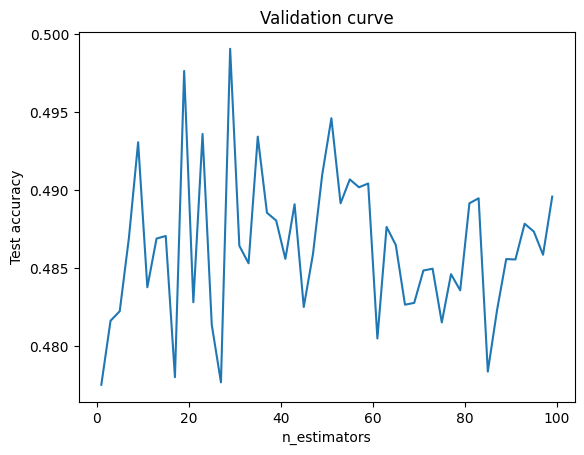

In [39]:
results = pd.DataFrame(bg_cl_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

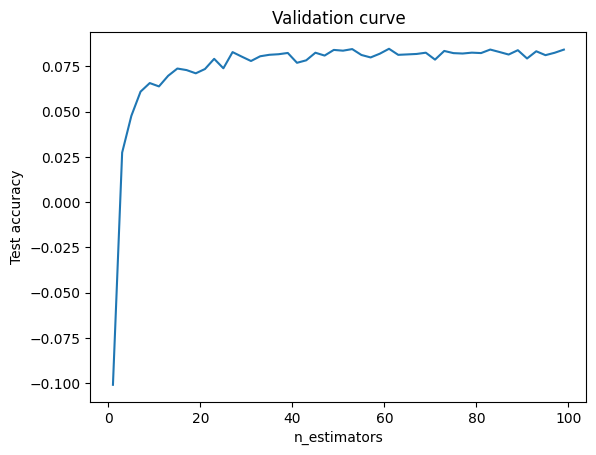

In [40]:
results = pd.DataFrame(bg_reg_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

We can see interesting moment that parameter `n_estimators` more effective for regressor than classifier, but not too much. On 20 regression have almoust the same result.

Lets try liear and logistic regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 

In [42]:
bagging_cl_lr = BaggingClassifier(LogisticRegression(), max_samples=0.5, max_features=1.0, n_estimators=10)
bagging_reg_lr = BaggingRegressor(LinearRegression(), max_samples=0.5, max_features=1.0, n_estimators=10)

In [43]:
bagging_cl_lr.fit(X_train_st_cl, y_train_cl)

BaggingClassifier(estimator=LogisticRegression(), max_samples=0.5)

In [44]:
bagging_reg_lr.fit(X_train_st_reg, y_train_reg)

BaggingRegressor(estimator=LinearRegression(), max_samples=0.5)

In [45]:
y_pred_cl = bagging_cl_lr.predict(X_valid_st_cl)
y_pred_reg = bagging_reg_lr.predict(X_valid_st_reg)

print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.4632082776498562
r2 score: 0.1570656391173565
f1 score: 0.5989528795811518


We have better result than 2 models earlier. Lets try make better accuracy with parameter

In [46]:
params_bg = { 'n_estimators': list(range(1, 40, 2)) }
bg_cllr_CV = GridSearchCV(bagging_cl_lr, params_bg, cv=5, scoring='f1')
bg_reglr_CV = GridSearchCV(bagging_reg_lr, params_bg, cv=5, scoring='r2')

In [47]:
bg_cllr_CV.fit(X_train_st_cl, y_train_cl)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=LogisticRegression(),
                                         max_samples=0.5),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='f1')

In [48]:
bg_reglr_CV.fit(X_train_st_reg, y_train_reg)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=LinearRegression(),
                                        max_samples=0.5),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='r2')

In [49]:
best_bgcl = bg_cllr_CV.best_estimator_
best_bgreg = bg_reglr_CV.best_estimator_
y_pred_cl = best_bgcl.predict(X_valid_st_cl)
y_pred_reg = best_bgreg.predict(X_valid_st_reg)
print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.46256972850412176
r2 score: 0.15822765422378504
f1 score: 0.6018808777429467


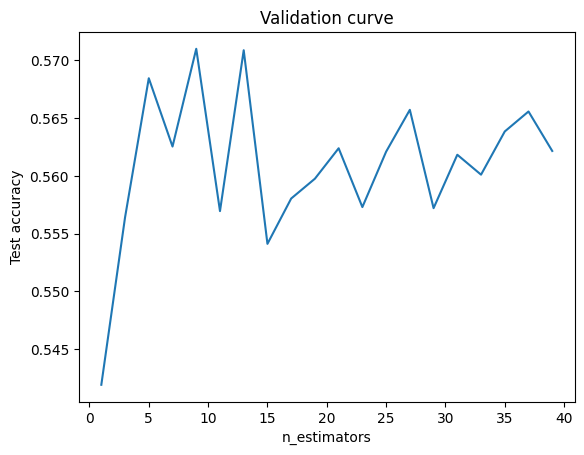

In [50]:
results = pd.DataFrame(bg_cllr_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

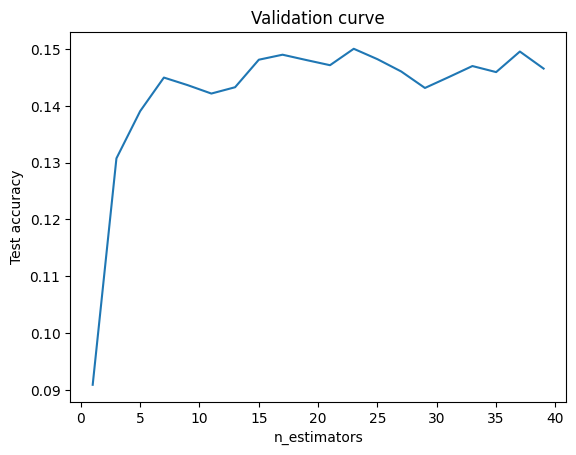

In [51]:
results = pd.DataFrame(bg_reglr_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

On this model parameter also didnt helped

## Boosting Tree

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [53]:
boosting_cl = GradientBoostingClassifier(n_estimators=10)
boosting_reg = GradientBoostingRegressor(n_estimators=10)

In [54]:
boosting_cl.fit(X_train_st_cl, y_train_cl)

GradientBoostingClassifier(n_estimators=10)

In [55]:
boosting_reg.fit(X_train_st_reg, y_train_reg)

GradientBoostingRegressor(n_estimators=10)

In [56]:
y_pred_cl = boosting_cl.predict(X_valid_st_cl)
y_pred_reg = boosting_reg.predict(X_valid_st_reg)

print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.45406836401322576
r2 score: 0.17369821593335089
f1 score: 0.514501891551072


We have the same result for classification and more much better result for regression. But let try make better result with parameters.

In [57]:
params_bg = { 'n_estimators': list(range(1, 50, 2)) }
bog_cl_CV = GridSearchCV(boosting_cl, params_bg, cv=5, scoring='f1')
bog_reg_CV = GridSearchCV(boosting_reg, params_bg, cv=5, scoring='r2')

In [58]:
bog_cl_CV.fit(X_train_st_cl, y_train_cl)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(n_estimators=10),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49]},
             scoring='f1')

In [59]:
bog_reg_CV.fit(X_train_st_reg, y_train_reg)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(n_estimators=10),
             param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49]},
             scoring='r2')

In [60]:
best_bogcl = bog_cl_CV.best_estimator_
best_bogreg = bog_reg_CV.best_estimator_
y_pred_cl = best_bogcl.predict(X_valid_st_cl)
y_pred_reg = best_bogreg.predict(X_valid_st_reg)
print("mean_squared_error score:", mean_squared_error(y_valid_reg, y_pred_reg))
print("r2 score:", r2_score(y_valid_reg, y_pred_reg))
print("f1 score:", f1_score(y_valid_cl, y_pred_cl))

mean_squared_error score: 0.426878902607294
r2 score: 0.2231768897369245
f1 score: 0.5852017937219731


We have the best result on this lab.

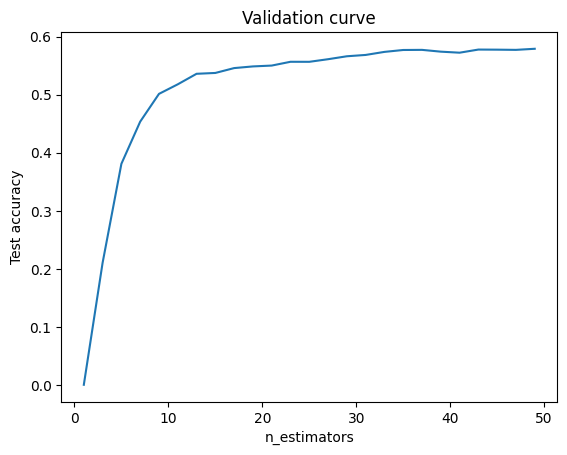

In [61]:
results = pd.DataFrame(bog_cl_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

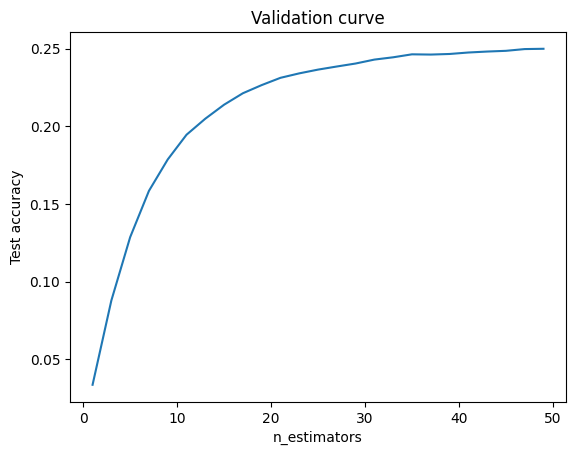

In [62]:
results = pd.DataFrame(bog_reg_CV.cv_results_)
plt.xlabel('n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.plot(results['param_n_estimators'], results['mean_test_score'])

We can see that on this case parameter more effective than another models. 

## Conclusions

<BarContainer object of 4 artists>

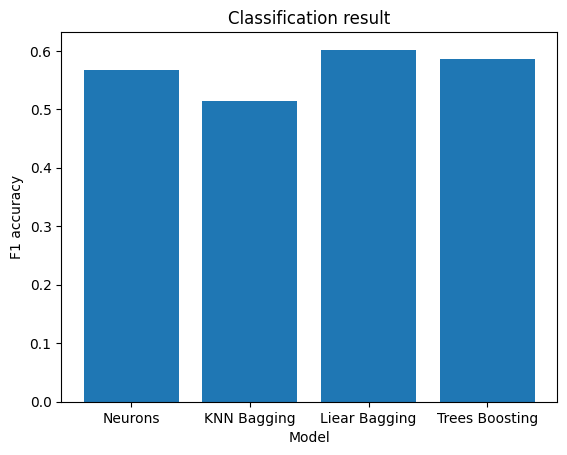

In [63]:
bests_cl = [MLPClassifier_CV.best_estimator_, bg_cl_CV.best_estimator_, bg_cllr_CV.best_estimator_, bog_cl_CV.best_estimator_]
results = []
for model in bests_cl:
    y_pred_cl =  model.predict(X_valid_st_cl) 
    results.append( f1_score(y_valid_cl, y_pred_cl) )
    
plt.title('Classification result')
plt.xlabel('Model')
plt.ylabel('F1 accuracy')
plt.bar(['Neurons', 'KNN Bagging', 'Liear Bagging', 'Trees Boosting'], results)

<BarContainer object of 4 artists>

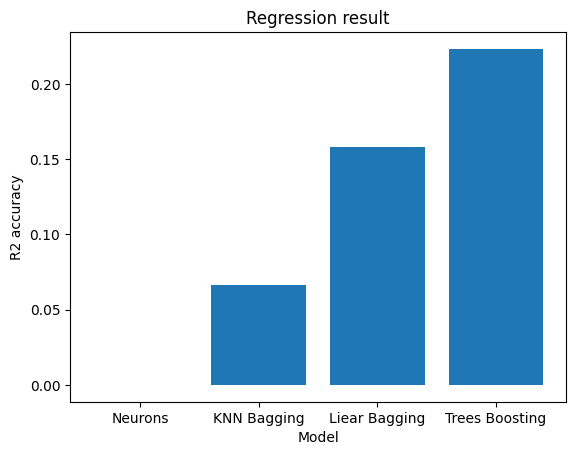

In [64]:
bests_reg = [MLPRegressor_CV.best_estimator_, bg_reg_CV.best_estimator_, bg_reglr_CV.best_estimator_, bog_reg_CV.best_estimator_]
results_r2 = []
results_mse = []
for model in bests_reg:
    y_pred_reg =  model.predict(X_valid_st_reg) 
    results_r2.append( r2_score(y_valid_reg, y_pred_reg) )
    results_mse.append( mean_squared_error(y_valid_reg, y_pred_reg) )
    

plt.title('Regression result')
plt.xlabel('Model')
plt.ylabel('R2 accuracy')
plt.bar(['Neurons', 'KNN Bagging', 'Liear Bagging', 'Trees Boosting'], results_r2)

<BarContainer object of 4 artists>

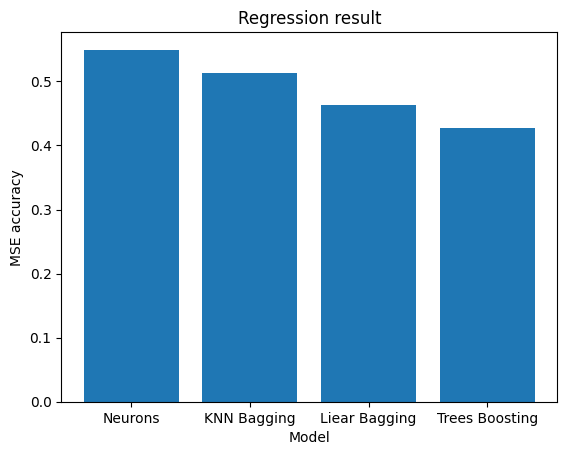

In [65]:
plt.title('Regression result')
plt.xlabel('Model')
plt.ylabel('MSE accuracy')
plt.bar(['Neurons', 'KNN Bagging', 'Liear Bagging', 'Trees Boosting'], results_mse)

For classification the worst result was KNN and the best boosting. For regresion the worst basic neurons, the best also is boosting. For classification bagging and boosting we have almoust the same result, but for regression bagging worse than boosting. It may cause on regresion we have higher displace than on classification. 

If we compare all models that we have viewed, Random Forest and Boosting Decision trees are the most effective for this data set.